# Topic Modeling with BERTopic

De nombreuse méthodes existent comme le « LDA » (latent dirichlet allocation) ou « Top2vec ». BERTopic est un autre algorithme qui a gagné en popularité ces dernières années.

BERTopic est à la fois le nom de l'algorithme et du module python développé par Maarten Grootendorst (2022) qui s’appuie par défaut sur des modèles « SBERT » (Sentence-Bert) pour plonger de courtes séquences de textes (des phrases) dans des embeddings. À l’aide de UMAP et HDBSCAN (comme pour Top2vec), BERTopic génère une clusterisation de ces séquences de textes. Enfin, chaque cluster est « labellisé » en fonction des 5 ou 10 mots les plus spécifiques. Cette spécificité est calculée à l’aide d’une variante du « Term Frequency – Inversed Document Frequency » (TF-IDF) : le « class-based TF-IDF ».

![](https://maartengr.github.io/BERTopic/algorithm/default.svg)

Je dis « par défaut», car «chaque  étage » de la fusée BERTopic peut être modifié selon les préférences des utilisateurs et utilisatrices. Il est ainsi possible d'utiliser d'autres modèles d'embedding, de réduire les dimensions à l'aide d'une analyse en composante principale (ACP ou PCA en anglais) et d'utiliser la méthode des k-means pour la clusterisation.


Dans notre cas, nous utiliserons les algorithmes par défaut de BERTopic (UMAP, HDBSCAN). Nous les appliquerons sur le corpus de tweets en français sur les pesticides publiés au cours  des dix dernières années. Il est disponible sur le github du cours : [https://github.com/luneauaymeric/pesticides_bertopic](https://github.com/luneauaymeric/pesticides_bertopic)

In [ ]:
!pip install numpy==1.26.4

In [1]:
import numpy
numpy.__version__

'1.26.4'

In [2]:
from tqdm.auto import tqdm
import bertopic
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

/home/aymeric/anaconda3/envs/audition/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation des données depuis github

In [3]:
url = 'https://raw.githubusercontent.com/luneauaymeric/pesticides_bertopic/refs/heads/main/datas/tweets_on_pesticides.csv' # liens vers le dépôt github 
path = "datas/tweets_on_pesticides.csv"
df = pd.read_csv(path) #On utilise pandas pour lire le csv

## Rapide aperçu de BERTopic

La détection de topic avec BERTopic peut se faire en 2 lignes de code avec la fonction `bertopic.BERTopic()`


In [ ]:
docs = df["text"].to_list()
model_bertopic = bertopic.BERTopic(language="multilingual", verbose=False)
topics_en_3_ligne, probs = model_bertopic.fit_transform(docs)


In [ ]:
model_bertopic.get_topic_info()

S'il suffit de 2 lignes pour obtenir des topics, la fonction .BERTopic() contient plusieurs paramètres dont la définition a des effets sur le résultats.

``` Pour voir la liste des arguments d'une fonction, il suffit de se placer dans la parenthèse et de taper Maj + Tab ```

Le premier est le choix de la langue. Celle par défaut est l'anglais (`language="english"`). L'autre option, celle que nous avons utilisée, est `"multilingual"`. La langue choisie détermine ensuite le modèle d'embedding qui sera utilisée.

Si `language = "english"` alors le modèle utilisé est `all-MiniLM-L6-v2`.

Si `language="multilingual"`, alors le modèle utilisé est`paraphrase-multilingual-MiniLM-L12-v2` (https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

Bien sûr, on verra ensuite qu'il est possible d'employer n'importe quel modèle disponible sur [huggingface](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2).



## Pre-process Text

Afin de rendre le résultat plus "lisible", il est utile de procéder à nettoyage minimal des textes, d'autant plus que nous travaillons sur des tweets. Ce nettoyage vise à retirer les urls, les émojis, les mentionned names et les caractères spéciaux.

On a besoin uniquement de la librairie `re`.



In [4]:
import re #librairie pour les regex



In [5]:
df["clean_text"] = df.apply(lambda row: re.sub(r"http\S+", "", str(row.text)).lower(), 1) # remove urls
df["clean_text"] = df.apply(lambda row: re.sub(r"_p_", "", str(row.clean_text)).lower(), 1)
df["clean_text"] = df.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.clean_text.split())), 1) #remove mentioned names
df["clean_text"] = df.apply(lambda row: re.sub("’", "'", str(row.clean_text)).lower(), 1) #replace "’" by "'"
df["clean_text"] = df.apply(lambda row: " ".join(re.sub("[^'a-zA-Zàâäéèêëïîôöùûüÿçß]+", " ", row.clean_text).split()), 1) #remove hashtag, arobase, HTML character
df["tokens"] = df.apply(lambda row: row.clean_text.split(),1) # 
df[["text", "clean_text", "tokens"]].head(10)

text  \
0  @JMHauteville Sam 03 Avril 15h Visioconférence...   
1  L'UE décide d'interdire trois pesticides dange...   
2  Concentration élevée de #glyphosate dans les u...   
3  Procès Monsanto : Un jury américain a condamné...   
4  @genefutures @vinel_benoit @petitnavire @Veill...   
5  @Thierry_28000 @fanch_mrl @M_Orphelin @Anses_f...   
6  Au détour d’un scrolling facebook, découverte ...   
7  @libe Une maman se bat pour son fils atteint d...   
8  Plan Ecophyto 2018 : une légère baisse de l'ut...   
9  La #FNSEA des empoisonneurs de la terre l'eau ...   

                                          clean_text  \
0  sam avril h visioconférence du sur le chlordéc...   
1  l'ue décide d'interdire trois pesticides dange...   
2  concentration élevée de glyphosate dans les ur...   
3  procès monsanto un jury américain a condamné v...   
4  sur le sujet des épices et graines contaminées...   
5  depuis quand l'ineris est responsable de l'hom...   
6  au détour d'un scrolling facebook découverte d...   
7  une maman se bat pour son fils atteint d'un ca...   
8  plan ecophyto une légère baisse de l'utilisati...   
9  la fnsea des empoisonneurs de la terre l'eau l...   

                                              tokens  
0  [sam, avril, h, visioconférence, du, sur, le, ...  
1  [l'ue, décide, d'interdire, trois, pesticides,...  
2  [concentration, élevée, de, glyphosate, dans, ...  
3  [procès, monsanto, un, jury, américain, a, con...  
4  [sur, le, sujet, des, épices, et, graines, con...  
5  [depuis, quand, l'ineris, est, responsable, de...  
6  [au, détour, d'un, scrolling, facebook, découv...  
7  [une, maman, se, bat, pour, son, fils, atteint...  
8  [plan, ecophyto, une, légère, baisse, de, l'ut...  
9  [la, fnsea, des, empoisonneurs, de, la, terre,...

On retire ensuite les tweets qui ont moins de trois tokens.

In [6]:
df["len_txt"] = df.tokens.str.len()
df1 = df.loc[(df.len_txt >= 3)].reset_index().drop(columns=["index"])

print(f"Il y a {len(df1)} tweets. Le plus long fait {max(df1.len_txt)} caractères.")


Il y a 19886 tweets. Le plus long fait 120 caractères.


- Visualisation de la distribution temporelle des tweets

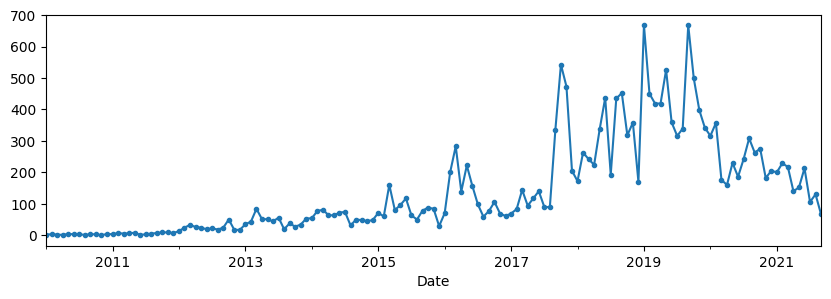

In [7]:
fig, ax=plt.subplots(1,figsize=(10,3))

df1["Date"] = pd.to_datetime(pd.to_datetime(df1['date']))
df1["num"] = 1 
df1.set_index("Date")["num"].resample("m").sum().plot(ax=ax,style=".-");

In [8]:
df1["text_id"] = "id_" + df1.index.astype(str) # on crée un id qu'on réutilisera plus bas

texts = df1.clean_text.to_list() #liste des textes nettoyés

## Décomposition de BERTopic

BERTopic est composé de quatre "étapes" :

1. Le plongement dans un embedding des phrases du corpus à l'aide d'un modèle _sentence transformers_
2. La réduction de la dimensionalité de l'embedding 
3. L'extraction de clusters
4. La labellisation des clusters en utilisant c-TF-IDF

Le point essentiel à retenir est que chacune des fonctions utilisées pour réaliser ces 4 étapes possèdent des paramètres dont la définition joue ensuite sur le résultat final.

### Embeddings


In [9]:
from sentence_transformers import SentenceTransformer
import pickle

La librairie `sentence_transformers` permet d'accéder facilement aux modèles hébergés sur [huggingface](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2).

`pickle` servira à enregistrer l'embedding pour une réutilisation ultérieure.

Une fois le modèle chargé, il peut être utile de vérifier que la taille maximale de la séquence admise par le modèle est égale ou supérieure à la taille du texte le plus long du corpus. Dans le cas contraire, les textes trop longs seront tronqués.

In [10]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("Taille maximale de la séquence : ", model.get_max_seq_length())

Taille maximale de la séquence :  128


- Ajoutez un commentaire à la ligne de code ci-dessous préciser ce qu'elle retourne

In [11]:
print(model.get_max_seq_length()>= max(df1.len_txt))

True


In [12]:
saved_embedding = True
if saved_embedding == True:
    with open('tw_embedding_paraphrase-multilingual-MiniLM-L12-v2_2.pickle', 'rb') as pkl:
        embeddings = pickle.load(pkl)
else:
    embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)
    with open('tw_embedding_paraphrase-multilingual-MiniLM-L12-v2_2.pickle', 'wb') as pkl:
        pickle.dump(embeddings, pkl)
    

### Réduction des dimensions avec UMAP




In [13]:
import numpy as np
import umap

#librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Une fois l’embedding réalisée, BERTopic fait appel à UMAP (Uniform Manifold Approximation and Projection) pour réduire le nombre de dimensions – qui est au départ de 384. 

UMAP est un algorithme qui cherche à préserver la structure locale (relation entre points proches) et la structure globale des données.

1. Le nombre de voisins : `n_neighbors`.
   
La balance entre la préservation des structures locales et globales est d'abord déterminée par le nombre de voisins (`n_neighbors`) de chaque point que l'algorithme prend en compte. Plus le `n_neighbors` est petit, plus UMAP préservera la structure locale des données. Inversement, plus `n_neighbors` est grand, plus UMAP rendra visible la structure globale au détriment des spécifités locales. 

Pour saisir l'effet de `n_neighbors`, on peut s'amuser à tracer une série de scatterplots.


100%|█████████████████████████████████████████████| 9/9 [01:30<00:00, 10.08s/it]


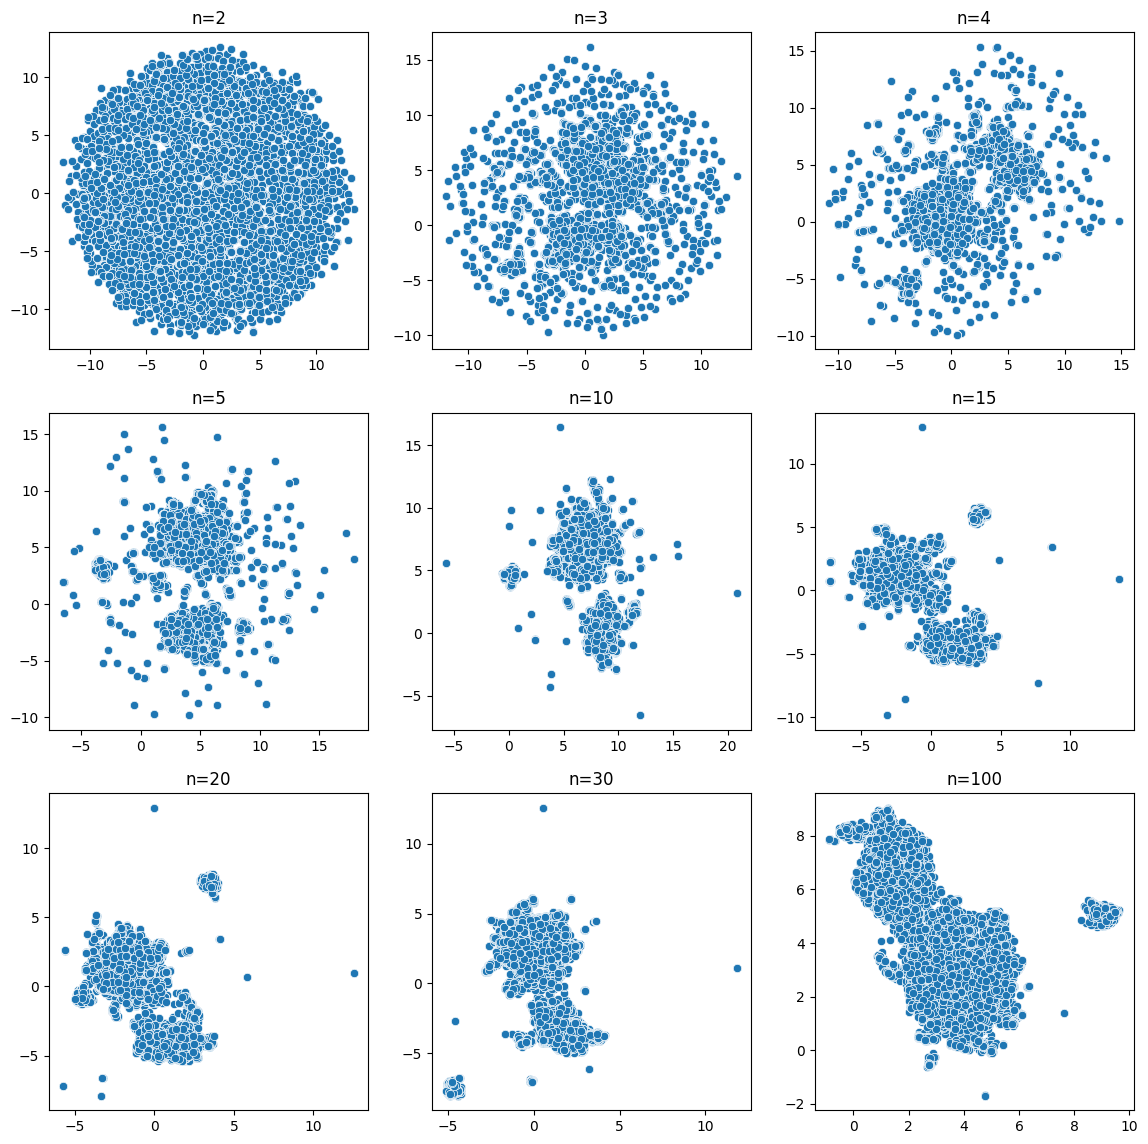

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nns = [2, 3, 4, 5, 10, 15, 20, 30, 100]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.00, n_components=2, random_state=42, metric = 'euclidean')
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1],  ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

En inspectant la fonction .UMAP, on remarque que 4 autres paramètres ont été définies:

2. `min_dist` : définit tout simplement la distance minimale entre les points que "umap" doit respecter lors de la projection. 

3. Le nombre de composantes (dimensions) : `n_components`

4. `metric` : métrique utilisée pour la distance entre les points.
   
5. Et le `random_state`, qu'il faut fixer avec une valeur quelconque pour pouvoir reproduire les résultats.



In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
nns = [0, 0.05, 0.1]
i= 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=10, random_state=42, n_components=2, min_dist=n_neighbors, metric='cosine')
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1],  ax=ax[i])
    ax[i].set_title(f'n={n_neighbors}')
    i+=1


Pour visualiser les effets de `n_neighbors` et `min_dist` sur le résultat produit par umap, on peu aussi s'amuser avec cette application streamlit: [https://fernando-lunap-streamlit-apps-umap-dashboard-fqce9m.streamlit.app/](https://fernando-lunap-streamlit-apps-umap-dashboard-fqce9m.streamlit.app/)

In [15]:
umap_model = umap.UMAP(n_neighbors=15, 
                       n_components=15, 
                       min_dist=0.00,
                       metric='cosine',
                       random_state=42)


### Clustering avec HDBSCAN

In [16]:
import hdbscan

Une fois la réduction des dimensions opérée à l'aide de umap, l'algorithme par défaut de BERTopic utilise l'algorithme HDBSCAN pour détecter les clusters.

Les deux principaux paramètres sont :
1. `min_cluster_size`
2. `min_samples`



In [17]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, 
                        min_samples= 5,
                        cluster_selection_method='eom', 
                        prediction_data=True)


### c-TF-IDF

Pour installer un modèle spacy (décommenter la ligne ci-dessous). On peut remplacer `fr_core_news_sm` par le modèle de son choix :
https://spacy.io/models

In [ ]:
#!python -m spacy download fr_core_news_sm

In [18]:
import spacy
from bertopic.vectorizers import ClassTfidfTransformer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

Après la clusterisation, BERTopic découpe les textes en tokens afin de calculer un _c-TF-IDF_ (class-based TF-IDF) et extraire ainsi les termes les plus spécifiques de chaque cluster. c-TF-IDF est une version modifiée du fameux _TF-IDF_ 

Pour rappel, $tf-idf(t, d, D) = tf(t,d) \times idf(t, D)$.

- $tf$ est la fréquence d'un terme $t$ dans le document $d$ rapporté aux nombres de termes de $d$. $\frac{f_{t,d}}{\sum_{t' \in d}{f_{t', d}}}$
- $idf$ est le log du nombre de documents  $D$ divisé par le nombre de documents contenant le terme $t$ : $\log(\frac{D}{\text{nombre de documents contenant t}})$

Dans le cas de c-TF-IDF, on s'intéresse à la fréquence des termes pour chaque classe (ou cluster).

$$c-tf-idf = \frac{f_{t,c}}{\sum_{t' \in c}{f_{t', c}}} \times \log \left(1+{\frac{\text{nombre moyen de termes par classe}}{\text{fréquence totale de t}}}\right)$$

Cette partie de l'algorithme affecte surtout les "labels" que BERTopic attribuera aux topics pour aider à leur interprétation. Il est donc utile de faire un peu de "nettoyage" en retirant par exemple les "stop words" (les mots trops fréquents qui apporte peu d'information).

Je propose ici d'utiliser la librairie `spacy` dont la liste des stop words français est un peu plus riche que celle implémentée dans `nltk.corpus`


In [27]:
nltk_french_stopwords = stopwords.words('french')
nlp = spacy.load('fr_core_news_sm')
print(f"stopwords.words('french') contient {len(stopwords.words('french'))} termes.\nnlp.Defaults.stop_words en contient {len(nlp.Defaults.stop_words)}.")

stopwords.words('french') contient 157 termes.
nlp.Defaults.stop_words en contient 507.


In [42]:
vectorizer_model = CountVectorizer(ngram_range=(1, 1),
                                   strip_accents='unicode',
                                    stop_words= [x for x in nlp.Defaults.stop_words])

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [43]:
topic_model = bertopic.BERTopic(
    language="multilingual",
    #embedding_model= model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    calculate_probabilities=True,        
    verbose=True
)

In [44]:
topics, probs = topic_model.fit_transform(texts, embeddings)

2024-10-02 14:43:51,635 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-02 14:44:03,179 - BERTopic - Dimensionality - Completed ✓
2024-10-02 14:44:03,180 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-02 14:44:05,570 - BERTopic - Cluster - Completed ✓
2024-10-02 14:44:05,573 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-02 14:44:05,818 - BERTopic - Representation - Completed ✓


In [45]:
print("Nombre de topics (moins les outliers) : ", len(set(topics))-1)

Nombre de topics (moins les outliers) :  21


## Analyser les topics

### Visualiser les topics



In [50]:
#topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=True, word_length=20, separator=", ")
#topic_model.set_topic_labels(topic_labels)
top_lab = topic_model.get_topic_info()
top_lab

Topic  Count                                           Name  \
0      -1   1848             -1_urines_oxyde_fonds_endocriniens   
1       0   7124          0_bio_agriculture_pesticides_synthese   
2       1   3644           1_glyphosate_circ_cancerigene_glypho   
3       2   1104      2_abeilles_tueurs_neonicotinoides_abeille   
4       3    878            3_france_europe_europeenne_francais   
5       4    761                 4_conservation_sols_sol_labour   
6       5    716  5_neonicotinoides_interdiction_loi_betteraves   
7       6    647            6_france_francais_europeenne_europe   
8       7    437                7_monsanto_bayer_dollars_brevet   
9       8    408      8_herbicide_herbicides_toxique_glyphosate   
10      9    325                       9_eau_eaux_cours_robinet   
11     10    263                10_enfants_ecoles_ecole_situees   
12     11    255               11_roundup_sdhi_desherbant_juges   
13     12    223                   12_cuivre_sulfate_soufre_bio   
14     13    196                   13_video_film_journaliste_tv   
15     14    196  14_chlordecone_martinique_guadeloupe_scandale   
16     15    177         15_cancers_cancer_sein_professionnelle   
17     16    171              16_monsanto_roundup_paul_francois   
18     17    144              17_fruits_legumes_fraises_tomates   
19     18    134                       18_vin_vins_bordeaux_hve   
20     19    126                     19_ogm_bt_permettent_coton   
21     20    109                  20_zero_communes_phyto_residu   

                                       Representation  \
0   [urines, oxyde, fonds, endocriniens, ethylene,...   
1   [bio, agriculture, pesticides, synthese, produ...   
2   [glyphosate, circ, cancerigene, glypho, scienc...   
3   [abeilles, tueurs, neonicotinoides, abeille, m...   
4   [france, europe, europeenne, francais, francai...   
5   [conservation, sols, sol, labour, acs, agricul...   
6   [neonicotinoides, interdiction, loi, betterave...   
7   [france, francais, europeenne, europe, europee...   
8   [monsanto, bayer, dollars, brevet, domaine, di...   
9   [herbicide, herbicides, toxique, glyphosate, p...   
10  [eau, eaux, cours, robinet, rivieres, nitrates...   
11  [enfants, ecoles, ecole, situees, traitez, aut...   
12  [roundup, sdhi, desherbant, juges, annule, pan...   
13  [cuivre, sulfate, soufre, bio, spinosad, utili...   
14  [video, film, journaliste, tv, escroquerie, ci...   
15  [chlordecone, martinique, guadeloupe, scandale...   
16  [cancers, cancer, sein, professionnelle, cance...   
17  [monsanto, roundup, paul, francois, records, s...   
18  [fruits, legumes, fraises, tomates, salades, r...   
19  [vin, vins, bordeaux, hve, vigne, champagne, v...   
20  [ogm, bt, permettent, coton, reduire, consider...   
21  [zero, communes, phyto, residu, film, cimetier...   

                                  Representative_Docs  
0   [rappelproduit dolactifs bio laboratoires syna...  
1   [stop aux pesticides chimiques de synthèse inu...  
2   [l'oms n'a pas classé le glyphosate cancérigèn...  
3   [les insecticides néonicotinoïdes tueurs d'abe...  
4   [mais les agriculteurs bio ils ne demandent qu...  
5   [c'est assez simple le glyphosate aux doses d'...  
6   [abeilles l'assemblée vote l'interdiction des ...  
7   [l' autriche tente à nouveau d'interdire le gl...  
8   [exclusif études sur le glyphosate financées s...  
9   [ce monsieur confond avec le gramoxone retiré ...  
10  [pollution des eaux un néonicotinoïde de plus ...  
11  [traitez en bio et hors présence enfants les z...  
12  [les sdhi sont utilisées depuis plus de études...  
13  [pourquoi les pesticides de synthèse seraient ...  
14  [je me disais bien qu'emma avait dû faire une ...  
15  [justice chlordécone martinique guadeloupe fra...  
16  [encore pris en flagrant délit de mauvaise foi...  
17  [l'agriculteur paul françois vient de remporte...  
18  [rapport sur les résidus de pesticides dans le...  
19  [ce qui n'est pas dit ici 

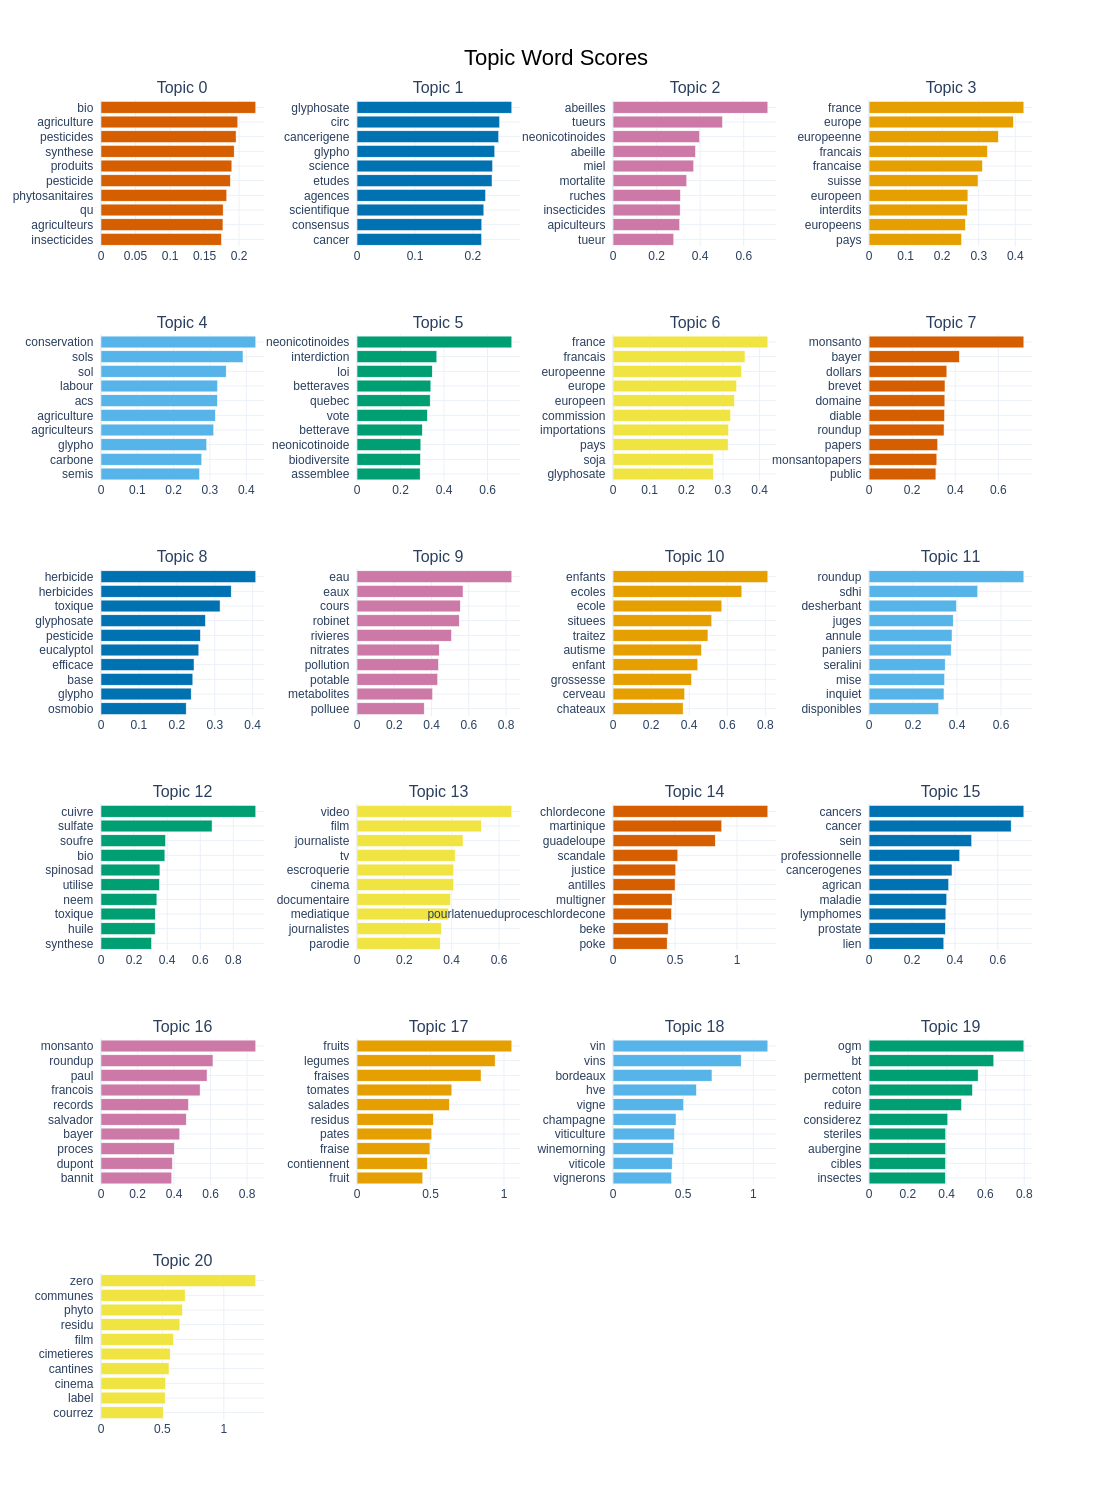

In [47]:
fig = topic_model.visualize_barchart(top_n_topics=46, n_words = 10)
fig
# Décommenter la ligne ci-dessous pour sauvegarder les diagramme
#fig.write_html(f'topic_word_scores_{len(topic_model.get_topic_info())}.html')

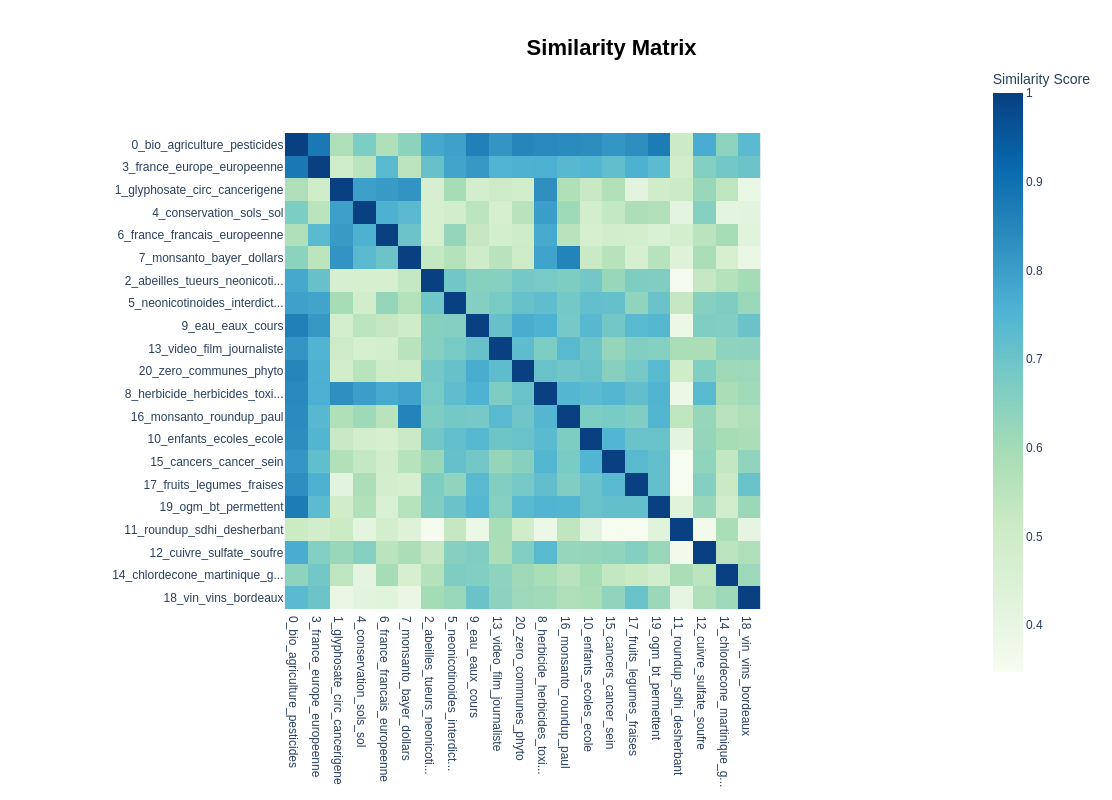

In [49]:
topic_model.visualize_heatmap(custom_labels=True, n_clusters=10)

Au risque d'anticiper sur la section suivante, il est possible de "customiser" les labels de différentes façons.

1. Méthode 1 : on demande à bertopic de générer des topics en concaténant les n premiers termes 

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=True, word_length=20, separator="_")
topic_model.set_topic_labels(topic_labels)

2. On renomme soit-même les topics

In [ ]:
topic_model.set_topic_labels({0:"Agriculture et pesticides", 2:"Néonics et abeilles"})
topic_model.get_topic_info().head(3)

### Labelliser les topics

La labellisation des topics suppose un travail d'interprétation. Si dans certains cas, les labels générés par bertopic (ci-après label bertopic) à travers la concaténation des n premiers termes peuvent suffir pour donner du sens aux topics, il s'avère souvent nécessaire de revenir aux textes initiaux pour s'assurer de la pertinence des topics d'une part et proposer une interprétation de ce qui unit les textes regroupés sous un même topic.

1. La première étape consiste à récupérer les informations sur les documents concernant le topic qui leur a été attribué avec la fonction `.get_document_info(<liste des documents>)`

In [ ]:
# 1. Récupération des infos sur les documents avec .get_document_info(). On enlève les colonne superflues
dftexts = topic_model.get_document_info(texts).drop(columns=["CustomName", "Representative_document", "Representative_Docs", "Top_n_words"])
dftexts["text_id"] = "id_" + dftexts.index.astype(str)

In [ ]:
# 2. On fusionne dftexts avec df1 (dataframe de départ) pour récupérer le texte original et la date de publication
df2 = df1[["text_id", "text", "Date","num"]].merge(dftexts, on = ["text_id"], how = "left")

2. On crée un dictionnaire contenant les numéro des topics et les noms que nous allons leurs donner (au départ ce dictionnaire est vide)

In [ ]:
topic_name = {
    -1 : "Outliers",
    0 : "Agricutlure intensive", #débat autour des modèles agricoles
    1 : "Les faits scientifiques sur le glyphosate", #Mise en avant du consensus scientifique autour du glyphosate.
    2 : "Abeilles et néonicotinoïdes", 
    3 : "Les pesticides en Frande, en Europe et dans le monde",
    4 : "Agriculture de conservation des sols",
    5 : "Interdiction des néonicotinoïdes",
    6 : "Réautorisation du glyphosate par la CE",
    7 : "Le lobbying de Monsanto",
    8 : "De la toxicité du glyphosate",
    9 : "Pollution des eaux",
    10 : "Zone de traitement et riverains (écoles)",
    11 : "Mises en cause des SDHI et autres alertes",
    12 : "Les phytosanitaires bios",
    13 : "Reportages sur les pesticides",
    14 : "Chlordécone",
    15 : "Cancers professionnels et pesticides",
    16 : "Les condamnations de Monsanto", #Affaires Paul François, Dawayne Jonhson
    17 : "Résidus de pesticides dans les aliments",
    18 : "Viticultures",
    19 : "OGM et pesticides",
    20 : "Objectif zéro phyto"
}

3. On va ensuite faire une boucle pour "sortir" tous les textes du topic que l'on veut inspecter. Une fois qu'on a trouver un nom, on reporte ce nom dans le dictionnaire ci-dessus.

In [ ]:
topic_no = 8 #numéro du topic à inspecter

# On filtre le dataframe pour ne garder que les textes appartenant au topic
dft = df2.loc[(df2["Topic"] == topic_no)]


In [ ]:
fig,ax=plt.subplots(1,figsize=(10,3))

dft.set_index("Date")["num"].resample("m").sum().plot(ax=ax,style=".-")

In [ ]:
print(dft.Representation.iloc[0]) ## J'imprime le label bertopic

for n, x in enumerate(dft.text): #Et pour chaque text de dft 
    print("###########")
    print(x)

4. On ajoute une colonne à `df2` contenant les nouveaux noms des topics. On fait la même chose pour `topic_model`)

In [ ]:
topic_model.set_topic_labels(topic_name) # fonction prévue par bertopic
df2["Topic_name"] = df2.Topic.map(topic_name.get)

5. Il peut-être utile également de récupérer les probabilités calculées par le modèle pour de future analyses.

In [ ]:
proba = pd.DataFrame(probs)
proba["text_id"] = "id_" + proba.index.astype(str)
df2 = df2.merge(proba, on =["text_id"], how="left")

In [ ]:
# Sauvegarde du dataframe dans un csv / décommenter la ligne ci-dessous
df2.to_csv("pesticides_on_twitter_with_metadata_umap_15_10_hdbscan_80_10.csv", index = False, sep =",")
# Save bertopic model - 
topic_model.save("embed_paraphrase-multilingual-MiniLM-L12-v2_umap_15_10_hdbscan_80_10_safetensors_2", serialization="safetensors", save_ctfidf=True, save_embedding_model=model)


In [ ]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, random_state=42).fit_transform(embeddings)

df2.loc[df2["Topic"] == -1, "Topic2"] = 21
df2.loc[df2["Topic"] > -1, "Topic2"] = df2.Topic


texts = [x for x in df2["text"]]
categories =  [x for x in df2["Topic2"]]
category_names = [x for x in df2.Topic_name]

result = pd.DataFrame(umap_model, columns=['a', 'b'])
result['category_names'] = category_names
result['texts'] = texts
scat_plot = px.scatter(result, x = "a", y= "b", color="category_names", hover_data=["category_names", "texts"])
scat_plot.write_html(f'scat_plot.html')

### Réduction des outliers

In [ ]:
topic_model = bertopic.BERTopic.load("embed_paraphrase-multilingual-MiniLM-L12-v2_umap_15_10_hdbscan_80_10_safetensors_2", embedding_model=model)

In [ ]:
new_topics = topic_model.reduce_outliers(texts, topics, embeddings = embeddings, strategy="embeddings")
#len(new_topics)

topic_model.update_topics(texts, topics=new_topics,vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model)
topic_model.get_topic_info()

In [ ]:
new_dftext = topic_model.get_document_info(texts)
new_dftext["text_id"] = "id_" + new_dftext.index.astype(str)
new_dftext["upd_topic_name"] = new_dftext.Topic.map(topic_name.get)
df3 = df2.merge(new_dftext[["text_id", "Topic",  "upd_topic_name"]].rename(columns={"Topic":"update_topic"}), on = ["text_id"], how = "left")
df3.upd_topic_name.loc[df3.Topic==-1].value_counts()


In [ ]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, random_state=42).fit_transform(embeddings)

df3.loc[df2["Topic"] == -1, "old_topic"] = 21
df3.loc[df2["Topic"] > -1, "old_topic"] = df3.Topic

texts = [x for x in df3["text"]]

category_names = [x for x in df3.upd_topic_name]
old_category_names = [x for x in df3.Topic_name]

result = pd.DataFrame(umap_model, columns=['a', 'b'])
result['category_names'] = category_names
result['texts'] = texts
result['old_category_names'] = old_category_names

scat_plot = px.scatter(result, x = "a", y= "b", color="category_names", symbol="old_category_names", hover_data=["category_names", "texts", "old_category_names"])
scat_plot.write_html(f'scat_plot.html')

## Semi-supervised topic

In [ ]:
path = "pesticides_on_twitter_with_metadata_umap_15_10_hdbscan_80_10.csv"
df2 = pd.read_csv(path, dtype= {"id": str, "user_id": str}) #On utilise pandas pour lire le csv

df2.loc[df2["Topic"] == -1, "Topic2"] = 21
df2.loc[df2["Topic"] > -1, "Topic2"] = df2.Topic


texts = [x for x in df2["Documents"]]

df2.loc[df2["Topic_id"] < 2, "masked_categories"] = -1
df2.loc[df2["Topic_id"] >= 2, "masked_categories"] = df2.Topic_id

masked_categories =  [x for x in df2["masked_categories"]]
category_names = [str(x) for x in df2["masked_categories"]]

#embedding_2 = umap.UMAP().fit_transform(data, y=target)

In [ ]:
result = pd.DataFrame(embedding, columns=['a', 'b'])
result['category_names'] = category_names
result['texts'] = texts
scat_plot = px.scatter(result, x = "a", y= "b", color="category_names", hover_data=["category_names", "texts"])
scat_plot.write_html(f'scat_plot2.html')

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=15, min_dist=0.00, random_state=42)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, 
                        metric='euclidean', 
                        min_samples= 5,
                        cluster_selection_method='eom', 
                        prediction_data=True)

final_stopwords_list = stopwords.words('french')

vectorizer_model = CountVectorizer(ngram_range=(1, 1),
                                   strip_accents='unicode',
                                   #tokenizer=tok, 
                                    stop_words= final_stopwords_list)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [ ]:
topic_model = bertopic.BERTopic(
    language="multilingual",
    #embedding_model= model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    calculate_probabilities=True,        
    verbose=True
)
topics, proba = topic_model.fit_transform(texts, embeddings, y=masked_categories)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=True, word_length=20, separator="_")
topic_model.set_topic_labels(topic_labels)
top_lab = topic_model.get_topic_info()
top_lab

In [ ]:
# 1. Récupération des infos sur les documents avec .get_document_info(). On enlève les colonne superflues
dftexts = topic_model.get_document_info(texts).drop(columns=["CustomName", "Representative_document", "Representative_Docs", "Top_n_words"])
dftexts["text_id"] = "id_" + dftexts.index.astype(str)

# 2. On fusionne dftexts avec df1 (dataframe de départ) pour récupérer le texte original et la date de publication
df3 = df2[["text_id", "text", "Date","num"]].merge(dftexts, on = ["text_id"], how = "left")


In [ ]:
topic_name = {
    -1 : "Outliers",
    0 : "Approche agronomique des pesticides", #débat autour des modèles agricoles point de vue agron
    1 : "Les faits scientfiques sur le glyphosate", #Mise en avant du consensus scientifique autour du glyphosate.
    2 : "Abeilles et néonicotinoïdes", 
    3 : "Agriculture de conservation des sols", 
    4 : "Les pesticides en Europes et dans le monde",
    5 : "Interdiction des néonicotinoïdes en question",
    6 : "La toxicité du glyphosate", 
    7 : "Le lobby Monsanto", #Annonce communication
    8 : "Effets sur la biodiversité",
    9 : "Pollutions des eaux",
    10 : "Actions contre les pesticides", #en justice
    11 : "Expositions des enfants",
    12 : "Chlordécone",
    13 : "Le sulfate de cuivre et autres phytosanitaires bios",
    14 : "La controverse sur les SDHI",
    15 : "Cancers professionnels et pesticides", #étude agrican
    16 : "L'affaire Paul Françaois", 
    17 : "Résidus de pesticides dans les aliments",
    18 : "Viticulture",
    19 : "Ogm et persticide",
    20 : "Communication salon de l\'agriculture"
}

In [ ]:
topic_no = 8 #numéro du topic à inspecter

# On filtre le dataframe pour ne garder que les textes appartenant au topic
dft = df3.loc[(df3["Topic"] == topic_no)]

fig,ax=plt.subplots(1,figsize=(10,3))

dft.set_index("Date")["num"].resample("m").sum().plot(ax=ax,style=".-")

In [ ]:
print(dft.Representation.iloc[0]) ## J'imprime le label bertopic

for n, x in enumerate(dft.text): #Et pour chaque text de dft 
    print("###########")
    print(x)

In [ ]:
topic_model.set_topic_labels(topic_name) # fonction prévue par bertopic
df3["Topic_name"] = df3.Topic.map(topic_name.get)


In [ ]:
topic_model.visualize_heatmap(n_clusters = 8, custom_labels=True)

In [ ]:
# Sauvegarde du dataframe dans un csv / décommenter la ligne ci-dessous
df2[['text_id', 'text', 'date', 'clean_text', 'tokens', 'len_txt',
       'Topic_id', 'Topic_lab', 'Topic_name']].to_csv("pesticides_on_twitter_semisupervised_topic.csv", index = False, sep =",")

## Unsupervised topic with new_embeddings

In [ ]:
path = "pesticides_on_twitter_semisupervised_topic.csv"
df2 = pd.read_csv(path, dtype= {"id": str, "user_id": str}) #On utilise pandas pour lire le csv

df3 = df2.loc[(df2.Topic_id == 0)]

df3.loc[df3["Topic_id"] < 2, "masked_categories"] = -1
df3.loc[df3["Topic_id"] >= 2, "masked_categories"] = df3.Topic_id

texts = [x for x in df3["clean_text"]]
categories =  [x for x in df3["Topic_id"]]
category_names = [str(x) for x in df3["Topic_id"]]
len(texts)

In [ ]:
new_embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.0, random_state=42).fit_transform(new_embeddings)

In [ ]:
result = pd.DataFrame(umap_model, columns=['a', 'b'])
result['category_names'] = category_names
result['texts'] = texts
scat_plot = px.scatter(result, x = "a", y= "b",  hover_data=["texts"])
scat_plot

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, n_components=10, min_dist=0.01, random_state=42)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=90, 
                        metric='euclidean', 
                        min_samples= 5,
                        cluster_selection_method='eom', 
                        prediction_data=True)

final_stopwords_list = stopwords.words('french')

vectorizer_model = CountVectorizer(ngram_range=(1, 1),
                                   strip_accents='unicode',
                                   #tokenizer=tok, 
                                    stop_words= final_stopwords_list)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [ ]:
topic_model = bertopic.BERTopic(
    language="multilingual",
    #embedding_model= model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    calculate_probabilities=True,        
    verbose=True
)
topics, proba = topic_model.fit_transform(texts, new_embeddings)

In [ ]:
topic_model.get_topic_info()